# ML HW2 sample code
TODO:
 - Design your CNN model (you are welcomed to use existing models)
 - Hyperparameter tuning

Report:
 - Data Augmentation
 - Draw the confusion matrix

#### Download data


In [1]:
!gdown 19oEShkdcBJf41nu46anyvu7BgXUffIGi
!unzip -q 'HW2.zip'

Downloading...
From (original): https://drive.google.com/uc?id=19oEShkdcBJf41nu46anyvu7BgXUffIGi
From (redirected): https://drive.google.com/uc?id=19oEShkdcBJf41nu46anyvu7BgXUffIGi&confirm=t&uuid=cd9ac440-bb99-49a3-a01b-615dd4d15abe
To: /content/HW2.zip
100% 52.1M/52.1M [00:00<00:00, 101MB/s]


#### Import packages

In [2]:
import os
import random
import csv
import torch
import torch.nn as nn
import numpy as np
import pandas as pd

import torchvision.transforms as T
from torchvision.transforms import v2
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader
from PIL import Image
from argparse import Namespace
from tqdm import tqdm

#### Hyperparameters and setting

In [3]:
# TODO: modify the hyperparameters
config = Namespace(
    random_seed = 42,
    BATCH = 256, #128
    n_epoch = 100, # default: 10
    lr = 3e-4, #default: 1e-4
    weight_decay = 1e-7,
    ckpt_path = 'model.pth',
)

In [4]:
TRA_PATH = 'data/train/'
TST_PATH = 'data/test/'
LABEL_PATH = 'data/train.csv'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.manual_seed(config.random_seed)
torch.cuda.manual_seed_all(config.random_seed)
random.seed(config.random_seed)
np.random.seed(config.random_seed)

#### Dataset and Dataloader

In [5]:
class FaceExpressionDataset(Dataset):
    def __init__(self, img_path, label_path=None, tfm=T.ToTensor()):
        n_samples = len(os.listdir(img_path))
        if label_path is not None:
            self.images = [f'{img_path}/{i+7000}.jpg' for i in range(n_samples)]
            self.labels = pd.read_csv(label_path)['label'].values.tolist()
        else:
            self.images = [f'{img_path}/{i}.jpg' for i in range(n_samples)]
            self.labels = None
        self.tfm = tfm

    def __getOrigItem__(self, idx):
        img = Image.open(self.images[idx])
        if self.labels is not None:
            lab = torch.tensor(self.labels[idx]).long()
            return img, lab
        else:
            return img

    def __getitem__(self, idx):
        img = Image.open(self.images[idx])
        img = self.tfm(img)
        # print(f"Shape after transform: {img.shape}")  # Debug print after transform
        if self.labels is not None:
            lab = torch.tensor(self.labels[idx]).long()
            return img, lab
        else:
            return img

    def __len__(self):
        return len(self.images)

In [6]:
# TODO: define your augmentation for training and evaluation
# Assisted by ChatGPT
train_tfm = v2.Compose([
    v2.ToImage(),  # Convert to tensor, only needed if you had a PIL image
    v2.ToDtype(torch.uint8, scale=True),  # Ensure input is uint8
    v2.RandomHorizontalFlip(p=0.5),  # Horizontal flip with 50% probability
    v2.RandomRotation(20),  # Random rotation between -10° to 10°
    v2.RandomPerspective(distortion_scale=0.3, p=0.4),  # Random perspective distortion
    # v2.RandomAffine(0, (0.1,0.1)),
    # v2.RandomAffine(20, (0.0,0.1), scale = (0.8, 1.0)),
    # Adding random noise (Gaussian)
    # v2.GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 3)),  # Slight blur to simulate noise


    # Brightness/Contrast adjustment for variability in lighting
    # v2.ColorJitter(brightness=0.2, contrast=0.3), # seems no use too


    # Normalize for grayscale image, using mean and std deviation of 0.5
    v2.ToDtype(torch.float32, scale=True),  # Convert to float
    # v2.Normalize(mean=[0.2], std=[0.5]),  # Normalize grayscale channel
])
eval_tfm = v2.Compose([
    v2.ToImage(),  # Convert to tensor, only needed if you had a PIL image
    # Adding random noise (Gaussian)
    # v2.GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 3)),  # Slight blur to simulate noise
    # guassianblur
    v2.ToDtype(torch.float32, scale=True),  # Convert to float
])


In [7]:
# dataset
train_dataset = FaceExpressionDataset(TRA_PATH, LABEL_PATH, tfm=train_tfm)
train_dataset, valid_dataset = torch.utils.data.random_split(train_dataset, [0.8, 0.2])
test_dataset = FaceExpressionDataset(TST_PATH, tfm=eval_tfm)

# dataloader
train_loader = DataLoader(train_dataset, batch_size=config.BATCH, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=config.BATCH, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=config.BATCH, shuffle=False)

##### Sad
Show Sad and Neutral images

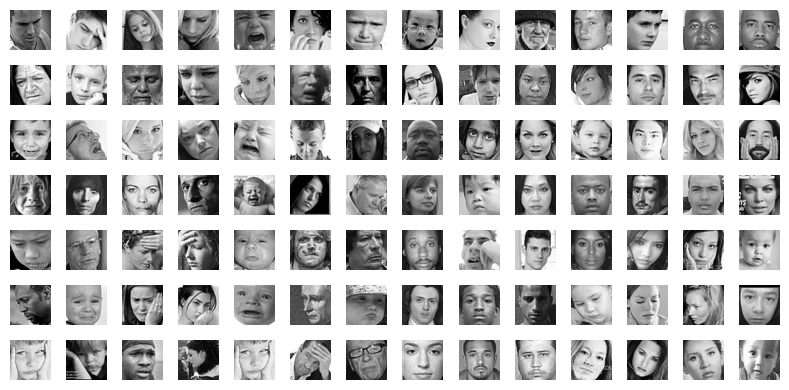

In [8]:
total_n = 49*2
n_row = 7
rand_arr = np.ones(total_n, dtype=int)
rand_arr = np.random.randint(len(train_dataset), size=total_n)
fig, axes = plt.subplots(n_row, (n_row * 2), figsize=(8, 4)) # Create a 5x5 grid of subplots

for i in range(total_n):
    row = i // (n_row*2)  # Calculate row index
    col = i % (n_row*2)   # Calculate column index
    image, label = train_dataset.dataset.__getOrigItem__(rand_arr[i])
    if col < n_row:
      while label != 4:
        image, label = train_dataset.dataset.__getOrigItem__(np.random.randint(len(train_dataset), size=1)[0])
    else:
      while label != 6:
        image, label = train_dataset.dataset.__getOrigItem__(np.random.randint(len(train_dataset), size=1)[0])
    axes[row, col].imshow(image, cmap='gray')  # Display image in the corresponding subplot
    axes[row, col].axis('off')  # Turn off axis labels and ticks

plt.tight_layout()  # Adjust subplot spacing
plt.show()

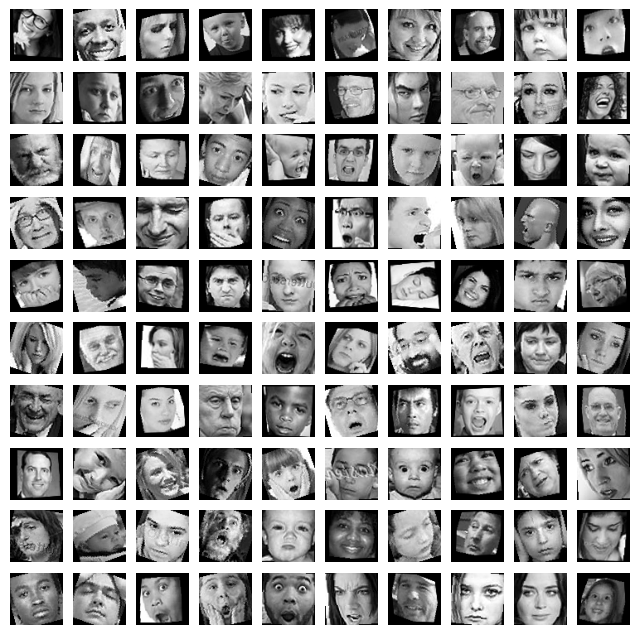

In [9]:
# Show Transformed images
def show_image(image_data):
  """Displays an image using matplotlib.

  Args:
    image_data: A NumPy array or PyTorch tensor representing the image data.
  """

  # If image_data is a PyTorch tensor, convert it to a NumPy array
  if hasattr(image_data, 'cpu'):
    image_data = image_data.cpu().numpy()

  # If the image has more than 3 channels (e.g., RGBA), select only the first 3
  if image_data.shape[0] > 3:
      image_data = image_data[:3]

  # If the image has shape (1, H, W), squeeze the first dimension
  if image_data.shape[0] == 1 and len(image_data.shape) == 3:
      image_data = image_data.squeeze(0)  # Remove the first dimension

  # Move the channel dimension to the last position if it's in the first position
  if image_data.shape[0] == 3 and len(image_data.shape) == 3:
      image_data = np.transpose(image_data, (1, 2, 0))

  # Clip values to be within the range [0, 1] if they aren't already
  image_data = np.clip(image_data, 0, 1)
  return(image_data)
  plt.imshow(image_data, cmap='gray')
  plt.axis('off')  # Turn off axis labels and ticks
  plt.show()

# Example usage with your image data:
# Assuming 'image_data' is your NumPy array or PyTorch tensor
fig, axes = plt.subplots(10, 10, figsize=(8, 8)) # Create a 5x5 grid of subplots

for i in range(100):
    row = i // 10  # Calculate row index
    col = i % 10   # Calculate column index
    image = show_image(train_dataset.__getitem__(i)[0])
    axes[row, col].imshow(image, cmap='gray')  # Display image in the corresponding subplot
    axes[row, col].axis('off')  # Turn off axis labels and ticks

# plt.tight_layout()  # Adjust subplot spacing
plt.show()

#### Model

In [10]:
class FaceExpressionNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(1, 256, kernel_size=3, stride=1, padding=1),
            # nn.BatchNorm2d(256), # Batch Normalization
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(256, 128, kernel_size=3, stride=1, padding=1),
            # nn.BatchNorm2d(128), # Batch Normalization
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            # nn.BatchNorm2d(128), # Batch Normalization
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Dropout(p=0.3),
        )
        # self.fc_input_size = 128 * (64 // (2**3)) * (64 // (2**3))  # 32 * 8 * 8 = 2048

        self.fc = nn.Sequential(
            nn.Linear(32 * 16 * 16, 128),
            # nn.Linear(self.fc_input_size, 128),
            nn.ReLU(),
            nn.Linear(128, 7)
        )

    def forward(self, x):
        x = self.conv(x)
        x = x.view(-1, 32 * 16 * 16)
        # x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

#### training loop

In [11]:
def train(model, train_loader, valid_loader, config):
    model.to(device)
    criteria = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=config.lr, weight_decay=config.weight_decay)

    best_acc = 0
    patience = 15  # Number of epochs to wait for improvement
    epochs_without_improvement = 0
    train_losses, valid_losses = [], []
    for epoch in range(config.n_epoch):
        # train
        model.train()
        train_loss, train_acc = 0, 0
        for img, lab in tqdm(train_loader):
            img, lab = img.to(device), lab.to(device)
            output = model(img)
            optimizer.zero_grad()
            loss = criteria(output, lab)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            train_acc += (torch.argmax(output, dim=-1) == lab).float().mean().item()
        train_loss, train_acc = train_loss/len(train_loader), train_acc/len(train_loader)
        train_losses.append(train_loss)
        print(f'Epoch: {epoch+1}/{config.n_epoch}, train loss: {train_loss:.4f}, train acc: {train_acc:.4f}')

        # valid
        model.eval()
        valid_loss, valid_acc = 0, 0
        with torch.no_grad():
            for img, lab in valid_loader:
                img, lab = img.to(device), lab.to(device)
                output = model(img)
                loss = criteria(output, lab)
                valid_loss += loss.item()
                valid_acc += (torch.argmax(output, dim=-1) == lab).float().mean().item()
        valid_loss, valid_acc = valid_loss/len(valid_loader), valid_acc/len(valid_loader)
        valid_losses.append(valid_loss)
        print(f'Epoch: {epoch+1}/{config.n_epoch}, valid loss: {valid_loss:.4f}, valid acc: {valid_acc:.4f}')

        # update
        if valid_acc > best_acc:
            best_acc = valid_acc
            torch.save(model.state_dict(), config.ckpt_path)
            print(f'== best valid acc: {best_acc:.4f} ==')
            epochs_without_improvement = 0  # Reset counter
        else:
            epochs_without_improvement += 1
            if epochs_without_improvement >= patience:
                print(f'Early stopping triggered after {epoch + 1} epochs.')
                break  # Exit training loop
    model.load_state_dict(torch.load(config.ckpt_path))

    # plot the training/validation loss curve
    plt.figure(figsize=(8, 6))
    plt.plot(range(len(train_losses)), train_losses, label='Training Loss')
    plt.plot(range(len(valid_losses)), valid_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    locs, labels = plt.xticks()
    plt.xticks(locs, locs.astype(int))
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

### Training w/o Data Argumentation

100%|██████████| 91/91 [00:22<00:00,  4.08it/s]


Epoch: 1/100, train loss: 1.7717, train acc: 0.2753
Epoch: 1/100, valid loss: 1.7358, valid acc: 0.3135
== best valid acc: 0.3135 ==


100%|██████████| 91/91 [00:22<00:00,  4.08it/s]


Epoch: 2/100, train loss: 1.6217, train acc: 0.3719
Epoch: 2/100, valid loss: 1.5932, valid acc: 0.3869
== best valid acc: 0.3869 ==


100%|██████████| 91/91 [00:23<00:00,  3.86it/s]


Epoch: 3/100, train loss: 1.5182, train acc: 0.4201
Epoch: 3/100, valid loss: 1.5142, valid acc: 0.4250
== best valid acc: 0.4250 ==


100%|██████████| 91/91 [00:22<00:00,  3.97it/s]


Epoch: 4/100, train loss: 1.4407, train acc: 0.4483
Epoch: 4/100, valid loss: 1.5145, valid acc: 0.4262
== best valid acc: 0.4262 ==


100%|██████████| 91/91 [00:22<00:00,  4.01it/s]


Epoch: 5/100, train loss: 1.3840, train acc: 0.4707
Epoch: 5/100, valid loss: 1.3946, valid acc: 0.4670
== best valid acc: 0.4670 ==


100%|██████████| 91/91 [00:22<00:00,  4.03it/s]


Epoch: 6/100, train loss: 1.3227, train acc: 0.4987
Epoch: 6/100, valid loss: 1.3617, valid acc: 0.4813
== best valid acc: 0.4813 ==


100%|██████████| 91/91 [00:22<00:00,  3.98it/s]


Epoch: 7/100, train loss: 1.2676, train acc: 0.5192
Epoch: 7/100, valid loss: 1.3277, valid acc: 0.4972
== best valid acc: 0.4972 ==


100%|██████████| 91/91 [00:22<00:00,  4.01it/s]


Epoch: 8/100, train loss: 1.2265, train acc: 0.5399
Epoch: 8/100, valid loss: 1.3111, valid acc: 0.5048
== best valid acc: 0.5048 ==


100%|██████████| 91/91 [00:22<00:00,  3.98it/s]


Epoch: 9/100, train loss: 1.1882, train acc: 0.5516
Epoch: 9/100, valid loss: 1.2908, valid acc: 0.5074
== best valid acc: 0.5074 ==


100%|██████████| 91/91 [00:22<00:00,  3.99it/s]


Epoch: 10/100, train loss: 1.1505, train acc: 0.5685
Epoch: 10/100, valid loss: 1.2812, valid acc: 0.5187
== best valid acc: 0.5187 ==


100%|██████████| 91/91 [00:22<00:00,  3.98it/s]


Epoch: 11/100, train loss: 1.1076, train acc: 0.5850
Epoch: 11/100, valid loss: 1.2750, valid acc: 0.5155


100%|██████████| 91/91 [00:22<00:00,  3.97it/s]


Epoch: 12/100, train loss: 1.0735, train acc: 0.5995
Epoch: 12/100, valid loss: 1.2769, valid acc: 0.5189
== best valid acc: 0.5189 ==


100%|██████████| 91/91 [00:22<00:00,  3.98it/s]


Epoch: 13/100, train loss: 1.0386, train acc: 0.6111
Epoch: 13/100, valid loss: 1.2653, valid acc: 0.5290
== best valid acc: 0.5290 ==


100%|██████████| 91/91 [00:22<00:00,  3.98it/s]


Epoch: 14/100, train loss: 1.0046, train acc: 0.6307
Epoch: 14/100, valid loss: 1.2499, valid acc: 0.5385
== best valid acc: 0.5385 ==


100%|██████████| 91/91 [00:22<00:00,  3.99it/s]


Epoch: 15/100, train loss: 0.9626, train acc: 0.6459
Epoch: 15/100, valid loss: 1.2460, valid acc: 0.5301


100%|██████████| 91/91 [00:22<00:00,  4.00it/s]


Epoch: 16/100, train loss: 0.9257, train acc: 0.6579
Epoch: 16/100, valid loss: 1.2463, valid acc: 0.5348


100%|██████████| 91/91 [00:22<00:00,  4.02it/s]


Epoch: 17/100, train loss: 0.8844, train acc: 0.6736
Epoch: 17/100, valid loss: 1.2484, valid acc: 0.5405
== best valid acc: 0.5405 ==


100%|██████████| 91/91 [00:22<00:00,  3.99it/s]


Epoch: 18/100, train loss: 0.8493, train acc: 0.6924
Epoch: 18/100, valid loss: 1.2929, valid acc: 0.5409
== best valid acc: 0.5409 ==


100%|██████████| 91/91 [00:22<00:00,  3.98it/s]


Epoch: 19/100, train loss: 0.8194, train acc: 0.6994
Epoch: 19/100, valid loss: 1.2775, valid acc: 0.5424
== best valid acc: 0.5424 ==


100%|██████████| 91/91 [00:22<00:00,  3.99it/s]


Epoch: 20/100, train loss: 0.7736, train acc: 0.7204
Epoch: 20/100, valid loss: 1.3230, valid acc: 0.5276


100%|██████████| 91/91 [00:22<00:00,  3.96it/s]


Epoch: 21/100, train loss: 0.7335, train acc: 0.7324
Epoch: 21/100, valid loss: 1.3204, valid acc: 0.5460
== best valid acc: 0.5460 ==


100%|██████████| 91/91 [00:22<00:00,  3.97it/s]


Epoch: 22/100, train loss: 0.7042, train acc: 0.7406
Epoch: 22/100, valid loss: 1.3301, valid acc: 0.5419


100%|██████████| 91/91 [00:22<00:00,  3.98it/s]


Epoch: 23/100, train loss: 0.6667, train acc: 0.7583
Epoch: 23/100, valid loss: 1.3483, valid acc: 0.5523
== best valid acc: 0.5523 ==


100%|██████████| 91/91 [00:22<00:00,  3.98it/s]


Epoch: 24/100, train loss: 0.6333, train acc: 0.7722
Epoch: 24/100, valid loss: 1.3927, valid acc: 0.5450


100%|██████████| 91/91 [00:22<00:00,  3.97it/s]


Epoch: 25/100, train loss: 0.6111, train acc: 0.7797
Epoch: 25/100, valid loss: 1.4090, valid acc: 0.5545
== best valid acc: 0.5545 ==


100%|██████████| 91/91 [00:22<00:00,  3.98it/s]


Epoch: 26/100, train loss: 0.5728, train acc: 0.7963
Epoch: 26/100, valid loss: 1.4273, valid acc: 0.5459


100%|██████████| 91/91 [00:22<00:00,  4.03it/s]


Epoch: 27/100, train loss: 0.5487, train acc: 0.8021
Epoch: 27/100, valid loss: 1.4430, valid acc: 0.5508


100%|██████████| 91/91 [00:22<00:00,  4.00it/s]


Epoch: 28/100, train loss: 0.5112, train acc: 0.8182
Epoch: 28/100, valid loss: 1.4971, valid acc: 0.5492


100%|██████████| 91/91 [00:22<00:00,  3.98it/s]


Epoch: 29/100, train loss: 0.4934, train acc: 0.8243
Epoch: 29/100, valid loss: 1.5273, valid acc: 0.5571
== best valid acc: 0.5571 ==


100%|██████████| 91/91 [00:22<00:00,  3.96it/s]


Epoch: 30/100, train loss: 0.4639, train acc: 0.8349
Epoch: 30/100, valid loss: 1.5719, valid acc: 0.5532


100%|██████████| 91/91 [00:22<00:00,  3.97it/s]


Epoch: 31/100, train loss: 0.4336, train acc: 0.8460
Epoch: 31/100, valid loss: 1.5935, valid acc: 0.5549


100%|██████████| 91/91 [00:22<00:00,  3.97it/s]


Epoch: 32/100, train loss: 0.4125, train acc: 0.8527
Epoch: 32/100, valid loss: 1.6382, valid acc: 0.5403


100%|██████████| 91/91 [00:22<00:00,  3.96it/s]


Epoch: 33/100, train loss: 0.3870, train acc: 0.8634
Epoch: 33/100, valid loss: 1.6737, valid acc: 0.5422


100%|██████████| 91/91 [00:22<00:00,  3.97it/s]


Epoch: 34/100, train loss: 0.3855, train acc: 0.8625
Epoch: 34/100, valid loss: 1.6878, valid acc: 0.5563


100%|██████████| 91/91 [00:23<00:00,  3.96it/s]


Epoch: 35/100, train loss: 0.3596, train acc: 0.8707
Epoch: 35/100, valid loss: 1.7172, valid acc: 0.5468


100%|██████████| 91/91 [00:23<00:00,  3.95it/s]


Epoch: 36/100, train loss: 0.3344, train acc: 0.8818
Epoch: 36/100, valid loss: 1.7487, valid acc: 0.5472


100%|██████████| 91/91 [00:22<00:00,  3.98it/s]


Epoch: 37/100, train loss: 0.3260, train acc: 0.8834
Epoch: 37/100, valid loss: 1.8143, valid acc: 0.5456


100%|██████████| 91/91 [00:22<00:00,  3.97it/s]


Epoch: 38/100, train loss: 0.3094, train acc: 0.8932
Epoch: 38/100, valid loss: 1.7923, valid acc: 0.5396


100%|██████████| 91/91 [00:22<00:00,  3.98it/s]


Epoch: 39/100, train loss: 0.2966, train acc: 0.8960
Epoch: 39/100, valid loss: 1.8621, valid acc: 0.5498


100%|██████████| 91/91 [00:22<00:00,  4.00it/s]


Epoch: 40/100, train loss: 0.2791, train acc: 0.9014
Epoch: 40/100, valid loss: 1.9299, valid acc: 0.5396


100%|██████████| 91/91 [00:22<00:00,  3.97it/s]


Epoch: 41/100, train loss: 0.2723, train acc: 0.9040
Epoch: 41/100, valid loss: 1.9295, valid acc: 0.5463


100%|██████████| 91/91 [00:22<00:00,  3.97it/s]


Epoch: 42/100, train loss: 0.2602, train acc: 0.9093
Epoch: 42/100, valid loss: 1.9509, valid acc: 0.5418


100%|██████████| 91/91 [00:22<00:00,  3.98it/s]


Epoch: 43/100, train loss: 0.2491, train acc: 0.9121
Epoch: 43/100, valid loss: 1.9492, valid acc: 0.5471


100%|██████████| 91/91 [00:22<00:00,  3.96it/s]


Epoch: 44/100, train loss: 0.2379, train acc: 0.9167
Epoch: 44/100, valid loss: 2.0202, valid acc: 0.5438
Early stopping triggered after 44 epochs.


<ipython-input-11-f5a8158d7bd1>:52: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(config.ckpt_path))


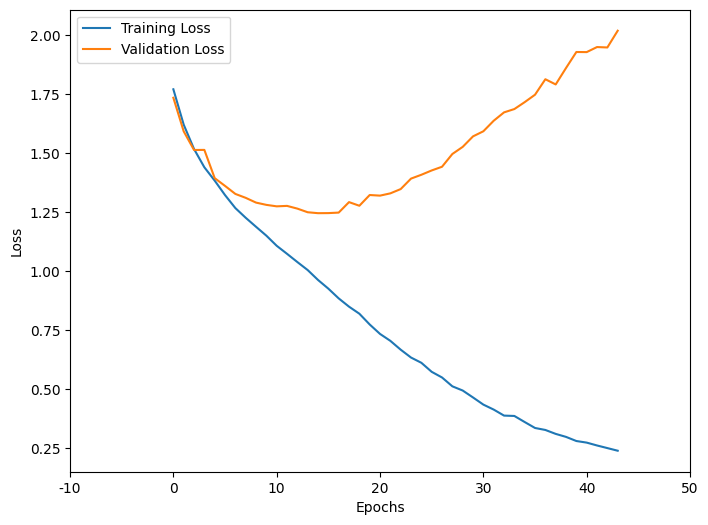

In [15]:
# w/o transformation
train_dataset = FaceExpressionDataset(TRA_PATH, LABEL_PATH, tfm=T.ToTensor())
train_dataset, valid_dataset = torch.utils.data.random_split(train_dataset, [0.8, 0.2])
train_loader = DataLoader(train_dataset, batch_size=config.BATCH, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=config.BATCH, shuffle=False)
model = FaceExpressionNet()
train(model, train_loader, valid_loader, config)

### Training
256-256-128 (dropout=0.3) flip + rotation(20) + RandomPerspective(distortion_scale=0.3, p=0.4), lr=3e-4

100%|██████████| 91/91 [00:54<00:00,  1.68it/s]


Epoch: 1/100, train loss: 1.7956, train acc: 0.2569
Epoch: 1/100, valid loss: 1.7749, valid acc: 0.2686
== best valid acc: 0.2686 ==


100%|██████████| 91/91 [00:49<00:00,  1.84it/s]


Epoch: 2/100, train loss: 1.7410, train acc: 0.2921
Epoch: 2/100, valid loss: 1.7068, valid acc: 0.3305
== best valid acc: 0.3305 ==


100%|██████████| 91/91 [00:49<00:00,  1.85it/s]


Epoch: 3/100, train loss: 1.6722, train acc: 0.3392
Epoch: 3/100, valid loss: 1.6294, valid acc: 0.3623
== best valid acc: 0.3623 ==


100%|██████████| 91/91 [00:49<00:00,  1.84it/s]


Epoch: 4/100, train loss: 1.6166, train acc: 0.3723
Epoch: 4/100, valid loss: 1.5781, valid acc: 0.3860
== best valid acc: 0.3860 ==


100%|██████████| 91/91 [00:49<00:00,  1.84it/s]


Epoch: 5/100, train loss: 1.5721, train acc: 0.3907
Epoch: 5/100, valid loss: 1.5284, valid acc: 0.4056
== best valid acc: 0.4056 ==


100%|██████████| 91/91 [00:49<00:00,  1.83it/s]


Epoch: 6/100, train loss: 1.5178, train acc: 0.4134
Epoch: 6/100, valid loss: 1.4804, valid acc: 0.4187
== best valid acc: 0.4187 ==


100%|██████████| 91/91 [00:49<00:00,  1.83it/s]


Epoch: 7/100, train loss: 1.4866, train acc: 0.4307
Epoch: 7/100, valid loss: 1.4542, valid acc: 0.4368
== best valid acc: 0.4368 ==


100%|██████████| 91/91 [00:49<00:00,  1.84it/s]


Epoch: 8/100, train loss: 1.4499, train acc: 0.4450
Epoch: 8/100, valid loss: 1.4114, valid acc: 0.4613
== best valid acc: 0.4613 ==


100%|██████████| 91/91 [00:50<00:00,  1.82it/s]


Epoch: 9/100, train loss: 1.4210, train acc: 0.4560
Epoch: 9/100, valid loss: 1.3852, valid acc: 0.4665
== best valid acc: 0.4665 ==


100%|██████████| 91/91 [00:50<00:00,  1.81it/s]


Epoch: 10/100, train loss: 1.3985, train acc: 0.4649
Epoch: 10/100, valid loss: 1.3672, valid acc: 0.4682
== best valid acc: 0.4682 ==


100%|██████████| 91/91 [00:49<00:00,  1.82it/s]


Epoch: 11/100, train loss: 1.3775, train acc: 0.4729
Epoch: 11/100, valid loss: 1.3783, valid acc: 0.4734
== best valid acc: 0.4734 ==


100%|██████████| 91/91 [00:49<00:00,  1.83it/s]


Epoch: 12/100, train loss: 1.3581, train acc: 0.4828
Epoch: 12/100, valid loss: 1.3692, valid acc: 0.4812
== best valid acc: 0.4812 ==


100%|██████████| 91/91 [00:50<00:00,  1.82it/s]


Epoch: 13/100, train loss: 1.3464, train acc: 0.4893
Epoch: 13/100, valid loss: 1.3243, valid acc: 0.4999
== best valid acc: 0.4999 ==


100%|██████████| 91/91 [00:50<00:00,  1.82it/s]


Epoch: 14/100, train loss: 1.3336, train acc: 0.4901
Epoch: 14/100, valid loss: 1.3023, valid acc: 0.5025
== best valid acc: 0.5025 ==


100%|██████████| 91/91 [00:50<00:00,  1.81it/s]


Epoch: 15/100, train loss: 1.3070, train acc: 0.5016
Epoch: 15/100, valid loss: 1.2997, valid acc: 0.5041
== best valid acc: 0.5041 ==


100%|██████████| 91/91 [00:50<00:00,  1.82it/s]


Epoch: 16/100, train loss: 1.3026, train acc: 0.5065
Epoch: 16/100, valid loss: 1.2911, valid acc: 0.5003


100%|██████████| 91/91 [00:50<00:00,  1.81it/s]


Epoch: 17/100, train loss: 1.2923, train acc: 0.5081
Epoch: 17/100, valid loss: 1.2737, valid acc: 0.5149
== best valid acc: 0.5149 ==


100%|██████████| 91/91 [00:49<00:00,  1.83it/s]


Epoch: 18/100, train loss: 1.2847, train acc: 0.5089
Epoch: 18/100, valid loss: 1.2681, valid acc: 0.5103


100%|██████████| 91/91 [00:50<00:00,  1.81it/s]


Epoch: 19/100, train loss: 1.2720, train acc: 0.5179
Epoch: 19/100, valid loss: 1.2709, valid acc: 0.5106


100%|██████████| 91/91 [00:50<00:00,  1.82it/s]


Epoch: 20/100, train loss: 1.2548, train acc: 0.5240
Epoch: 20/100, valid loss: 1.2633, valid acc: 0.5133


100%|██████████| 91/91 [00:50<00:00,  1.82it/s]


Epoch: 21/100, train loss: 1.2523, train acc: 0.5249
Epoch: 21/100, valid loss: 1.2468, valid acc: 0.5244
== best valid acc: 0.5244 ==


100%|██████████| 91/91 [00:50<00:00,  1.81it/s]


Epoch: 22/100, train loss: 1.2447, train acc: 0.5259
Epoch: 22/100, valid loss: 1.2365, valid acc: 0.5274
== best valid acc: 0.5274 ==


100%|██████████| 91/91 [00:50<00:00,  1.81it/s]


Epoch: 23/100, train loss: 1.2350, train acc: 0.5332
Epoch: 23/100, valid loss: 1.2391, valid acc: 0.5242


100%|██████████| 91/91 [00:50<00:00,  1.81it/s]


Epoch: 24/100, train loss: 1.2298, train acc: 0.5337
Epoch: 24/100, valid loss: 1.2249, valid acc: 0.5274


100%|██████████| 91/91 [00:50<00:00,  1.81it/s]


Epoch: 25/100, train loss: 1.2170, train acc: 0.5360
Epoch: 25/100, valid loss: 1.2119, valid acc: 0.5396
== best valid acc: 0.5396 ==


100%|██████████| 91/91 [00:49<00:00,  1.82it/s]


Epoch: 26/100, train loss: 1.2032, train acc: 0.5427
Epoch: 26/100, valid loss: 1.2155, valid acc: 0.5251


100%|██████████| 91/91 [00:50<00:00,  1.82it/s]


Epoch: 27/100, train loss: 1.1923, train acc: 0.5503
Epoch: 27/100, valid loss: 1.1943, valid acc: 0.5458
== best valid acc: 0.5458 ==


100%|██████████| 91/91 [00:50<00:00,  1.81it/s]


Epoch: 28/100, train loss: 1.1869, train acc: 0.5518
Epoch: 28/100, valid loss: 1.1960, valid acc: 0.5410


100%|██████████| 91/91 [00:49<00:00,  1.82it/s]


Epoch: 29/100, train loss: 1.1868, train acc: 0.5502
Epoch: 29/100, valid loss: 1.2032, valid acc: 0.5315


100%|██████████| 91/91 [00:50<00:00,  1.82it/s]


Epoch: 30/100, train loss: 1.1695, train acc: 0.5562
Epoch: 30/100, valid loss: 1.1963, valid acc: 0.5436


100%|██████████| 91/91 [00:50<00:00,  1.81it/s]


Epoch: 31/100, train loss: 1.1668, train acc: 0.5564
Epoch: 31/100, valid loss: 1.1805, valid acc: 0.5457


100%|██████████| 91/91 [00:50<00:00,  1.80it/s]


Epoch: 32/100, train loss: 1.1633, train acc: 0.5594
Epoch: 32/100, valid loss: 1.1939, valid acc: 0.5371


100%|██████████| 91/91 [00:50<00:00,  1.80it/s]


Epoch: 33/100, train loss: 1.1565, train acc: 0.5618
Epoch: 33/100, valid loss: 1.1714, valid acc: 0.5463
== best valid acc: 0.5463 ==


100%|██████████| 91/91 [00:49<00:00,  1.82it/s]


Epoch: 34/100, train loss: 1.1440, train acc: 0.5680
Epoch: 34/100, valid loss: 1.1787, valid acc: 0.5464
== best valid acc: 0.5464 ==


100%|██████████| 91/91 [00:50<00:00,  1.82it/s]


Epoch: 35/100, train loss: 1.1417, train acc: 0.5676
Epoch: 35/100, valid loss: 1.1694, valid acc: 0.5525
== best valid acc: 0.5525 ==


100%|██████████| 91/91 [00:50<00:00,  1.81it/s]


Epoch: 36/100, train loss: 1.1356, train acc: 0.5731
Epoch: 36/100, valid loss: 1.1608, valid acc: 0.5603
== best valid acc: 0.5603 ==


100%|██████████| 91/91 [00:50<00:00,  1.81it/s]


Epoch: 37/100, train loss: 1.1271, train acc: 0.5741
Epoch: 37/100, valid loss: 1.1688, valid acc: 0.5487


100%|██████████| 91/91 [00:50<00:00,  1.81it/s]


Epoch: 38/100, train loss: 1.1209, train acc: 0.5749
Epoch: 38/100, valid loss: 1.1671, valid acc: 0.5545


100%|██████████| 91/91 [00:50<00:00,  1.81it/s]


Epoch: 39/100, train loss: 1.1224, train acc: 0.5731
Epoch: 39/100, valid loss: 1.1745, valid acc: 0.5479


100%|██████████| 91/91 [00:49<00:00,  1.83it/s]


Epoch: 40/100, train loss: 1.1139, train acc: 0.5782
Epoch: 40/100, valid loss: 1.1482, valid acc: 0.5626
== best valid acc: 0.5626 ==


100%|██████████| 91/91 [00:49<00:00,  1.82it/s]


Epoch: 41/100, train loss: 1.1058, train acc: 0.5859
Epoch: 41/100, valid loss: 1.1567, valid acc: 0.5617


100%|██████████| 91/91 [00:50<00:00,  1.82it/s]


Epoch: 42/100, train loss: 1.0993, train acc: 0.5868
Epoch: 42/100, valid loss: 1.1577, valid acc: 0.5603


100%|██████████| 91/91 [00:49<00:00,  1.82it/s]


Epoch: 43/100, train loss: 1.0975, train acc: 0.5846
Epoch: 43/100, valid loss: 1.1612, valid acc: 0.5512


100%|██████████| 91/91 [00:49<00:00,  1.82it/s]


Epoch: 44/100, train loss: 1.0920, train acc: 0.5862
Epoch: 44/100, valid loss: 1.1379, valid acc: 0.5636
== best valid acc: 0.5636 ==


100%|██████████| 91/91 [00:50<00:00,  1.82it/s]


Epoch: 45/100, train loss: 1.0835, train acc: 0.5901
Epoch: 45/100, valid loss: 1.1464, valid acc: 0.5623


100%|██████████| 91/91 [00:50<00:00,  1.82it/s]


Epoch: 46/100, train loss: 1.0794, train acc: 0.5930
Epoch: 46/100, valid loss: 1.1374, valid acc: 0.5578


100%|██████████| 91/91 [00:50<00:00,  1.82it/s]


Epoch: 47/100, train loss: 1.0818, train acc: 0.5933
Epoch: 47/100, valid loss: 1.1349, valid acc: 0.5621


100%|██████████| 91/91 [00:49<00:00,  1.82it/s]


Epoch: 48/100, train loss: 1.0773, train acc: 0.5952
Epoch: 48/100, valid loss: 1.1349, valid acc: 0.5678
== best valid acc: 0.5678 ==


100%|██████████| 91/91 [00:50<00:00,  1.81it/s]


Epoch: 49/100, train loss: 1.0750, train acc: 0.5944
Epoch: 49/100, valid loss: 1.1405, valid acc: 0.5630


100%|██████████| 91/91 [00:50<00:00,  1.81it/s]


Epoch: 50/100, train loss: 1.0706, train acc: 0.5955
Epoch: 50/100, valid loss: 1.1443, valid acc: 0.5637


100%|██████████| 91/91 [00:50<00:00,  1.81it/s]


Epoch: 51/100, train loss: 1.0665, train acc: 0.5949
Epoch: 51/100, valid loss: 1.1200, valid acc: 0.5710
== best valid acc: 0.5710 ==


100%|██████████| 91/91 [00:49<00:00,  1.83it/s]


Epoch: 52/100, train loss: 1.0584, train acc: 0.5992
Epoch: 52/100, valid loss: 1.1412, valid acc: 0.5625


100%|██████████| 91/91 [00:50<00:00,  1.80it/s]


Epoch: 53/100, train loss: 1.0556, train acc: 0.6018
Epoch: 53/100, valid loss: 1.1376, valid acc: 0.5622


100%|██████████| 91/91 [00:50<00:00,  1.81it/s]


Epoch: 54/100, train loss: 1.0529, train acc: 0.6014
Epoch: 54/100, valid loss: 1.1208, valid acc: 0.5687


100%|██████████| 91/91 [00:49<00:00,  1.82it/s]


Epoch: 55/100, train loss: 1.0488, train acc: 0.6013
Epoch: 55/100, valid loss: 1.1299, valid acc: 0.5704


100%|██████████| 91/91 [00:49<00:00,  1.83it/s]


Epoch: 56/100, train loss: 1.0390, train acc: 0.6084
Epoch: 56/100, valid loss: 1.1280, valid acc: 0.5724
== best valid acc: 0.5724 ==


100%|██████████| 91/91 [00:49<00:00,  1.83it/s]


Epoch: 57/100, train loss: 1.0367, train acc: 0.6119
Epoch: 57/100, valid loss: 1.1248, valid acc: 0.5688


100%|██████████| 91/91 [00:50<00:00,  1.82it/s]


Epoch: 58/100, train loss: 1.0365, train acc: 0.6080
Epoch: 58/100, valid loss: 1.1280, valid acc: 0.5665


100%|██████████| 91/91 [00:50<00:00,  1.81it/s]


Epoch: 59/100, train loss: 1.0293, train acc: 0.6084
Epoch: 59/100, valid loss: 1.1189, valid acc: 0.5696


100%|██████████| 91/91 [00:50<00:00,  1.81it/s]


Epoch: 60/100, train loss: 1.0284, train acc: 0.6127
Epoch: 60/100, valid loss: 1.1170, valid acc: 0.5719


100%|██████████| 91/91 [00:49<00:00,  1.82it/s]


Epoch: 61/100, train loss: 1.0211, train acc: 0.6161
Epoch: 61/100, valid loss: 1.1207, valid acc: 0.5661


100%|██████████| 91/91 [00:50<00:00,  1.82it/s]


Epoch: 62/100, train loss: 1.0181, train acc: 0.6182
Epoch: 62/100, valid loss: 1.1276, valid acc: 0.5679


100%|██████████| 91/91 [00:49<00:00,  1.82it/s]


Epoch: 63/100, train loss: 1.0138, train acc: 0.6190
Epoch: 63/100, valid loss: 1.1074, valid acc: 0.5790
== best valid acc: 0.5790 ==


100%|██████████| 91/91 [00:49<00:00,  1.83it/s]


Epoch: 64/100, train loss: 1.0151, train acc: 0.6179
Epoch: 64/100, valid loss: 1.1134, valid acc: 0.5745


100%|██████████| 91/91 [00:49<00:00,  1.82it/s]


Epoch: 65/100, train loss: 1.0118, train acc: 0.6179
Epoch: 65/100, valid loss: 1.1196, valid acc: 0.5718


100%|██████████| 91/91 [00:50<00:00,  1.82it/s]


Epoch: 66/100, train loss: 1.0076, train acc: 0.6229
Epoch: 66/100, valid loss: 1.1034, valid acc: 0.5852
== best valid acc: 0.5852 ==


100%|██████████| 91/91 [00:49<00:00,  1.82it/s]


Epoch: 67/100, train loss: 1.0069, train acc: 0.6172
Epoch: 67/100, valid loss: 1.1297, valid acc: 0.5672


100%|██████████| 91/91 [00:50<00:00,  1.81it/s]


Epoch: 68/100, train loss: 1.0077, train acc: 0.6222
Epoch: 68/100, valid loss: 1.1136, valid acc: 0.5740


100%|██████████| 91/91 [00:49<00:00,  1.82it/s]


Epoch: 69/100, train loss: 0.9990, train acc: 0.6218
Epoch: 69/100, valid loss: 1.1123, valid acc: 0.5747


100%|██████████| 91/91 [00:49<00:00,  1.82it/s]


Epoch: 70/100, train loss: 0.9956, train acc: 0.6249
Epoch: 70/100, valid loss: 1.1139, valid acc: 0.5771


100%|██████████| 91/91 [00:49<00:00,  1.82it/s]


Epoch: 71/100, train loss: 0.9900, train acc: 0.6287
Epoch: 71/100, valid loss: 1.1219, valid acc: 0.5769


100%|██████████| 91/91 [00:54<00:00,  1.66it/s]


Epoch: 72/100, train loss: 0.9906, train acc: 0.6307
Epoch: 72/100, valid loss: 1.1136, valid acc: 0.5777


100%|██████████| 91/91 [00:50<00:00,  1.81it/s]


Epoch: 73/100, train loss: 0.9883, train acc: 0.6307
Epoch: 73/100, valid loss: 1.1232, valid acc: 0.5707


100%|██████████| 91/91 [00:51<00:00,  1.78it/s]


Epoch: 74/100, train loss: 0.9810, train acc: 0.6293
Epoch: 74/100, valid loss: 1.1143, valid acc: 0.5768


100%|██████████| 91/91 [00:50<00:00,  1.82it/s]


Epoch: 75/100, train loss: 0.9717, train acc: 0.6360
Epoch: 75/100, valid loss: 1.1085, valid acc: 0.5823


100%|██████████| 91/91 [00:50<00:00,  1.81it/s]


Epoch: 76/100, train loss: 0.9796, train acc: 0.6315
Epoch: 76/100, valid loss: 1.1098, valid acc: 0.5776


100%|██████████| 91/91 [00:49<00:00,  1.82it/s]


Epoch: 77/100, train loss: 0.9797, train acc: 0.6302
Epoch: 77/100, valid loss: 1.1210, valid acc: 0.5783


100%|██████████| 91/91 [00:50<00:00,  1.81it/s]


Epoch: 78/100, train loss: 0.9708, train acc: 0.6323
Epoch: 78/100, valid loss: 1.1100, valid acc: 0.5839


100%|██████████| 91/91 [00:50<00:00,  1.81it/s]


Epoch: 79/100, train loss: 0.9671, train acc: 0.6360
Epoch: 79/100, valid loss: 1.1046, valid acc: 0.5787


100%|██████████| 91/91 [00:50<00:00,  1.82it/s]


Epoch: 80/100, train loss: 0.9698, train acc: 0.6357
Epoch: 80/100, valid loss: 1.1197, valid acc: 0.5738


100%|██████████| 91/91 [00:50<00:00,  1.82it/s]


Epoch: 81/100, train loss: 0.9674, train acc: 0.6404
Epoch: 81/100, valid loss: 1.1173, valid acc: 0.5827
Early stopping triggered after 81 epochs.


<ipython-input-11-f5a8158d7bd1>:52: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(config.ckpt_path))


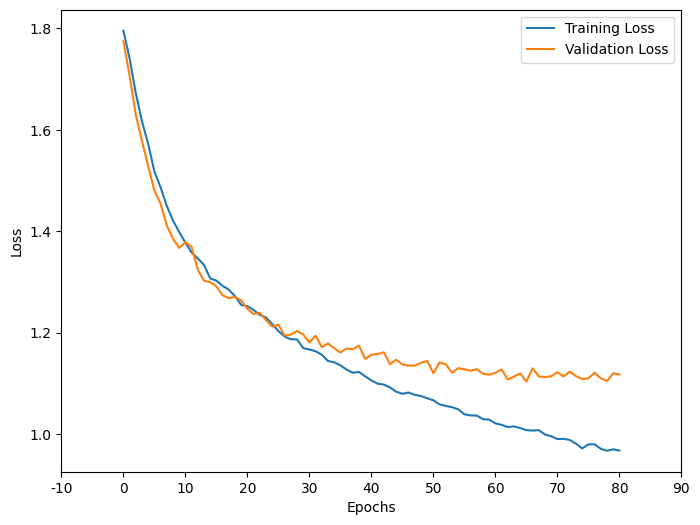

In [ ]:
model = FaceExpressionNet()
train(model, train_loader, valid_loader, config)

100%|██████████| 23/23 [00:09<00:00,  2.37it/s]


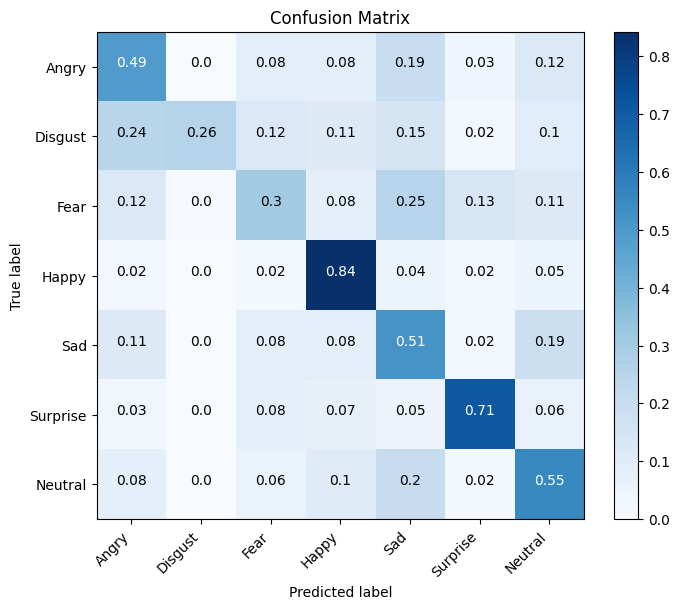

<Figure size 640x480 with 0 Axes>

In [ ]:
# prompt: modify the chuck above to draw confusion matrix using graphically
# Assited by Gemini
def draw_confusion_matrix(model, valid_loader):
    predictions, labels = [], []
    model.to(device)
    model.eval()
    with torch.no_grad():
        for img, lab in tqdm(valid_loader):
            img = img.to(device)
            output = model(img)
            predictions += torch.argmax(output, dim=-1).tolist()
            labels += lab.tolist()
        cm = np.zeros((7, 7), dtype=int)
        for label, prediction in zip(labels, predictions):
            cm[label, prediction] += 1
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    classes = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
    # Plot the confusion matrix using matplotlib
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar(fraction=0.046, pad=0.04)

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, ha='right')  # Rotate x-axis labels
    plt.yticks(tick_marks, classes)

    # Improved text display:
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
          plt.text(j, i, format(np.round(cm[i, j],2)),
                  horizontalalignment="center",
                  color="white" if cm[i, j] > thresh else "black",
                  fontsize=10  # Adjust font size as needed
                  )
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

    plt.tight_layout()
    plt.show()
draw_confusion_matrix(model, valid_loader)

### Testing

In [ ]:
test_dataset = FaceExpressionDataset(TST_PATH, tfm=eval_tfm)
test_loader = DataLoader(test_dataset, batch_size=config.BATCH, shuffle=False)
def test(model, test_loader):
    predictions = []
    model.to(device)
    model.eval()
    with torch.no_grad():
        for img in tqdm(test_loader):
            img = img.to(device)
            output = model(img)
            predictions += torch.argmax(output, dim=-1).tolist()
    with open('predict.csv', 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(['id', 'label'])
        for id, r in enumerate(predictions):
            writer.writerow([id, r])

In [ ]:
# from google.colab import files

model.load_state_dict(torch.load('model.pth'))
test(model, test_loader)
# files.download('predict.csv')

<ipython-input-16-3e75953d8231>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('model.pth'))
100%|██████████| 28/28 [00:05<00:00,  4.71it/

NameError: name 'files' is not defined


### Without Argmentation: